## Notebook for Solar Wind Exploration

In the initial phase, we want to see if we can detect FTEs using unsupervised learning, by finding a manifold for the solar wind data.

The initial hypothesis is the transition matrices (Markov Matrices $M$) that can be derived from Manifolder + clustering will show distinctive clusters and transitions.  We can check accuracy by looking at the label (FTE or not?), and see if this label could have been deduced from the data itself.



In [1]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set()

import pandas as pd

import time

import random

### Load Solar Wind Data, and Run Manifolder

The `dataset_2` file contains 

Dataset-2 (THEMIS):   a list with FTEs periods and non-FTEs periods observed by THEMIS in 2007.  These are combined into one file, randomly FTE - NonFTE - FTE - FTE, NonFTE, etc…

In total there are 63 FTEs and 47 non-FTEs.

The time series are separated by one blank line, and each one has 1440 points in a period of 6 minutes.


In [2]:
import sys
sys.path.append(r"C:\Users\acloninger\GDrive\ac2528Backup\DocsFolder\GitHub\manifolder")
sys.path.append(r"..")

import manifolder as mr
from manifolder import helper as mh


In [3]:
# load the data
# note, you must have started the notebook in the 

print('loading data ...')
df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)
df.head()


loading data ...


,bx\t,by\t,bz\t,bl\t,bm\t,bn\t,bmag\t,vx\t,vy\t,vz\t,vmag\t,np,Unnamed: 13,tpar,tper,tp,goal
sc time,,,,,,,,,,,,,,,,,
thd,1.177999e+09,2.06,-4.87,17.77,17.80,4.55,-2.48,18.54,-5.96,2.42,6.94,9.46,0.11,3938.25,3565.04,3689.44,1.0
thd,1.177999e+09,2.01,-4.89,17.69,17.72,4.53,-2.53,18.47,-7.04,1.11,6.79,9.85,0.11,3924.28,3610.40,3715.03,1.0
thd,1.177999e+09,2.01,-4.87,17.71,17.74,4.51,-2.52,18.48,-8.14,-0.21,6.66,10.52,0.11,3910.35,3656.06,3740.82,1.0
thd,1.177999e+09,2.02,-4.80,17.74,17.77,4.47,-2.45,18.48,-9.23,-1.53,6.52,11.40,0.11,3896.40,3701.56,3766.51,1.0
thd,1.177999e+09,1.99,-4.83,17.70,17.73,4.47,-2.50,18.45,-10.26,-2.82,6.37,12.40,0.11,3882.37,3746.46,3791.77,1.0


In [4]:
# convert values from loaded spreadsheet, into a numpy matrices
# note that there is no need for the first value, which is time,
# as it is not part of the manifold
#
# also, note the spreadsheet is missing a column name for `Unnamed: 13`, and the values above
# this have the incorrect column labels; the first relevant vale is bx, which as a magnitude around 2
#
# note the final value of each row is the goal (0 or 1), and not part of z

data_raw = df.values[:, 1:]
print('first line of raw_data:\n', data_raw[0, :])


first line of raw_data:
 [   2.06   -4.87   17.77   17.8     4.55   -2.48   18.54   -5.96    2.42
    6.94    9.46    0.11 3938.25 3565.04 3689.44    1.  ]


In [5]:
import pickle
#Load Data
segments = np.load('themis\segments-newdata-all.npy')

# Load Labels
labels = np.load('themis\labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)

In [50]:
# loop through the data, breaking out the clusters
# i will always point to the NaN (blank line) in the dataframe,
# and values [i-1440:i] is the snipped

snippet_len = 1440

# collect all line breaks (blank lines) in csv file
#lineBreaks = [0]
#for i in range(data_raw.shape[0]):
#    if data_raw[i,0] != data_raw[i,0]:  # replacement of isnan, since nan != nan
#        lineBreaks.append(i)    
#lineBreaks.append(data_raw.shape[0])
#
#num_snippet = len(lineBreaks)-1


# callect the snippets into two groups, one for each goal (target) value, 0 or 1
# these can be easily merged
zs_0 = []
zs_1 = []

locallabel_0 = []
locallabel_1 = []
snippet_index = 0;

df.values[0,:]

reduce_dimension = True

for i in range(snippet_len,data_raw.shape[0],snippet_len+1):
    # copy the snipped, excluding the last value, which is the goal
    snippet = data_raw[i-snippet_len:i,:-1]
    
    if reduce_dimension:
        snippet = snippet[:,5]
        #snippet = snippet[:,8]
        snippet = snippet.reshape(snippet_len,1)

    # grab the goal value from the first row of each snippet
    goal = data_raw[i-snippet_len,-1]
    
    # check to make sure each snippet does not contain NaN
    # (should not, if parsing is correct)
    assert ~np.isnan(snippet).any(), 'oops, snippet contains a Nan!'
    
    print('snippet size',snippet.shape,'with goal',goal)
    
    snippetlabel = np.zeros(snippet_len)
    if goal == 1:
        bmin = int(bboxes[snippet_index][0][0])
        bmax = int(bboxes[snippet_index][0][2])
        snippetlabel[bmin:bmax] = 1
    
    if goal == 0:
        zs_0.append( snippet )
        locallabel_0.append( snippetlabel )
    elif goal == 1:
        zs_1.append( snippet )
        locallabel_1.append( snippetlabel )
    else:
        assert False, 'value of goal not understood'
        
    snippet_index = snippet_index + 1;
        

# shuffle this lists; this should not strictly be necessary, if all the data is being used,
# but prevents biases when shortening the list

c0 = list(zip(zs_0, locallabel_0))
random.shuffle(c0)
zs_0, locallabel_0 = zip(*c0)
zs_0 = list(zs_0)
locallabel_0 = list(locallabel_0)

c1 = list(zip(zs_1, locallabel_1))
random.shuffle(c1)
zs_1, locallabel_1 = zip(*c1)
zs_1 = list(zs_1)
locallabel_1 = list(locallabel_1)

shorten_data = False

if shorten_data:
    zs_0 = zs_0[:20]
    zs_1 = zs_1[:20]
    locallabel_0 = locallabel_0[:20]
    locallabel_1 = locallabel_1[:20]
        
zs = zs_0 + zs_1
locallabel = locallabel_0 + locallabel_1
z_breakpoint = len(zs_0)

print( '\done!')
print( '\t len(zs_0):',len(zs_0))
print( '\t len(zs_1):',len(zs_1))
print( '\t len(zs):',len(zs))


snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
s

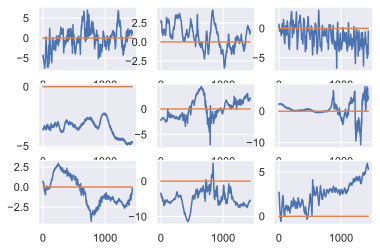

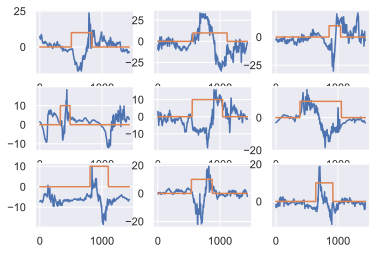

In [33]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_0[i][:,5])
    else:
        plt.plot(zs_0[i][:,0])
        
    plt.plot(10*locallabel_0[i])
    
plt.show()

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_1[i][:,5])
    else:
        plt.plot(zs_1[i][:,0])
    plt.plot(10*locallabel_1[i])

    
plt.show()

In [34]:
# data has been parsed, now run Manifolder

dim=8
H = 160
step_size = 20
nbins = 10
ncov = 10

start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(dim=dim,H=H,step_size=step_size,nbins=nbins, ncov=ncov)

# add the data, and fit (this runs all the functions)
manifolder.fit_transform(zs, parallel=False)

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)


calculating histograms for snip  0  of  103  (dim  1  timeseries) . done
calculating histograms for snip  1  of  103  (dim  1  timeseries) . done
calculating histograms for snip  2  of  103  (dim  1  timeseries) . done
calculating histograms for snip  3  of  103  (dim  1  timeseries) . done
calculating histograms for snip  4  of  103  (dim  1  timeseries) . done
calculating histograms for snip  5  of  103  (dim  1  timeseries) . done
calculating histograms for snip  6  of  103  (dim  1  timeseries) . done
calculating histograms for snip  7  of  103  (dim  1  timeseries) . done
calculating histograms for snip  8  of  103  (dim  1  timeseries) . done
calculating histograms for snip  9  of  103  (dim  1  timeseries) . done
calculating histograms for snip  10  of  103  (dim  1  timeseries) . done
calculating histograms for snip  11  of  103  (dim  1  timeseries) . done
calculating histograms for snip  12  of  103  (dim  1  timeseries) . done
calculating histograms for snip  13  of  103  (d

computing local covariances for snip  9  of  103......... done
computing local covariances for snip  10  of  103......... done
computing local covariances for snip  11  of  103......... done
computing local covariances for snip  12  of  103......... done
computing local covariances for snip  13  of  103......... done
computing local covariances for snip  14  of  103......... done
computing local covariances for snip  15  of  103......... done
computing local covariances for snip  16  of  103......... done
computing local covariances for snip  17  of  103......... done
computing local covariances for snip  18  of  103......... done
computing local covariances for snip  19  of  103......... done
computing local covariances for snip  20  of  103......... done
computing local covariances for snip  21  of  103......... done
computing local covariances for snip  22  of  103......... done
computing local covariances for snip  23  of  103......... done
computing local covariances for snip  24 

In [35]:
locallabel_downsample = np.empty(0, float)
for i in range(len(locallabel)):
    x = locallabel[i]
    x = x[0:x.shape[0]-H]
    x = x[::step_size]

    locallabel_downsample = np.append(locallabel_downsample,x,0)
    
Psi = manifolder.Psi[:,0:manifolder.Dim]
    
print(locallabel_downsample.shape)
print(Psi.shape)

(6592,)
(6592, 8)


In [ ]:
plt.scatter(manifolder.Psi[:,0],manifolder.Psi[:,2],c=locallabel_downsample,cmap='jet')

# Nearest Neighbor prediction of locallabel with snippet level splits

In [36]:
import sklearn

test_size = .33
val_size = 0

snippet_label = manifolder.snip_number
num_snips_0 = int(len(zs_0))
num_snips_1 = int(len(zs_1))


snip_indices_0 = np.random.permutation(num_snips_0)
snip_indices_1 = np.random.permutation(num_snips_1) + num_snips_0

n_train_0 = int((1-test_size-val_size)*num_snips_0)
n_val_0 = int(val_size*num_snips_0)
snip_train_0 = snip_indices_0[0:n_train_0]
snip_val_0 = snip_indices_0[n_train_0:n_train_0+n_val_0]
snip_test_0 = snip_indices_0[n_train_0+n_val_0: num_snips_0]

n_train_1 = int((1-test_size-val_size)*num_snips_1)
n_val_1 = int(val_size*num_snips_1)
snip_train_1 = snip_indices_1[0:n_train_1]
snip_val_1 = snip_indices_1[n_train_1:n_train_1+n_val_1]
snip_test_1 = snip_indices_1[n_train_1+n_val_1: num_snips_1]


X_train = Psi[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1))),:]
y_train = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1)))]
X_val = Psi[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1))),:]
y_val = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1)))]
X_test = Psi[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1))),:]
y_test = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1)))]


In [37]:
CM = sklearn.metrics.confusion_matrix(y_train.astype(int), y_train.astype(int))
total = np.sum(CM)
pos = CM[1,1]

class_weight = {0: 1.,
                1: total/pos}

print('Examples in Training:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))



Examples in Training:
    Total: 4352
    Positive: 506 (11.63% of total)



In [38]:
dist = sklearn.metrics.pairwise_distances(X_train)
inds = np.argsort(dist,axis=1)

percentCorrect = np.zeros(25)
for knn in range(1,25):
    predict_class = np.median(y_train[inds[:,1:knn+1]],axis=1)  # Could replace with "is there a label" or class_weight
    predict_class = predict_class.astype(int) 
    CM = sklearn.metrics.confusion_matrix(y_train.astype(int), predict_class )
    percentCorrect[knn] = CM[1,1]/np.sum(CM[:,1])
    
print(percentCorrect)

knn = np.argmax(percentCorrect)
print(knn)



dist = sklearn.metrics.pairwise_distances(X_test,X_train)
inds = np.argsort(dist,axis=1)

predict_class = np.median(y_train[inds[:,0:knn]],axis=1)
predict_class = predict_class.astype(int) 


CM = sklearn.metrics.confusion_matrix(y_test.astype(int), predict_class )
print('Window Level Confusion:')
print(CM)


[0.     0.6564 0.7524 0.6842 0.7244 0.6756 0.7099 0.6838 0.7014 0.6809
 0.703  0.6859 0.6977 0.6749 0.6903 0.6759 0.7003 0.6792 0.6813 0.6544
 0.6712 0.6617 0.664  0.6608 0.6604]
2
Window Level Confusion:
[[1869  112]
 [ 196   63]]


Number Ground Truth Labeld Points per Snippet:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 27 25 14 16 11  5  5 10
 23  9 13 20 18  8  9  9 13 15  9]
Number Predicted Labeld Points per Snippet:
[ 0  0  0  0  1  0  0  0  0  0  0  0  3  0  0 10 10  5  0  9  9  1 31  4
 10 12  1  0  9  9  6 13  6 13 13]
Snippet Level Confusion:
[[13  3]
 [ 2 17]]


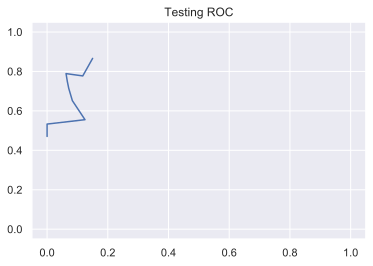

In [39]:
thresholdFromTrain=0

falsepos = np.zeros(25)
truepos = np.zeros(25)
for threshold in range(25):
    numsnips = (num_snips_0-(n_train_0+n_val_0)) + (num_snips_1-(n_train_1+n_val_1))
    numpts = (predict_class.shape[0])//numsnips
    
    prediction_snippet = predict_class.reshape(numsnips,numpts)
    y_snippet = y_test.reshape(numsnips,numpts)

    snippet_true = np.sum(y_snippet,axis=1) > 0
    snippet_predict = np.sum(prediction_snippet,axis=1) > threshold
    
    CM = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
    falsepos[threshold] = CM[0,1]/(np.sum(CM[:,1])+.01)
    truepos[threshold] = CM[0,0]/(np.sum(CM[:,0])+.01)
    
    
plt.plot(falsepos,truepos)
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)
plt.title('Testing ROC')

snippet_true = np.sum(y_snippet,axis=1) > 0
snippet_predict = np.sum(prediction_snippet,axis=1) > thresholdFromTrain 
CM_test = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )

print('Number Ground Truth Labeld Points per Snippet:')
print(np.sum(y_snippet.astype(int),axis=1))
print('Number Predicted Labeld Points per Snippet:')
print(np.sum(prediction_snippet,axis=1))

print('Snippet Level Confusion:')
print(CM_test)

In [40]:
dist = sklearn.metrics.pairwise_distances(Psi,X_train)
inds = np.argsort(dist,axis=1)

pred_all = np.median(y_train[inds[:,0:knn]],axis=1)
pred_all_class = pred_all.astype(int) 


z_downsample = np.empty((0,zs[0].shape[1]+1), float)
for i in range(len(zs)):
    x = zs[i]
    x = x[0:x.shape[0]-H,:]
    x = x[::step_size]
    if i<z_breakpoint:
        x = np.append(x,np.zeros((x.shape[0],1)),1)
    else:
        x = np.append(x,np.ones((x.shape[0],1)),1)

    z_downsample = np.append(z_downsample,x,0)
    
z_downsample = np.append(z_downsample, manifolder.snip_number.reshape(Psi.shape[0],1), 1)
z_downsample = np.append(z_downsample, pred_all_class.reshape(Psi.shape[0],1), 1)
    
z_downsample.shape

(6592, 4)

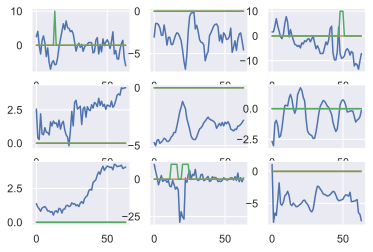

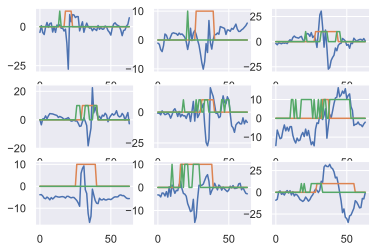

In [41]:
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(z_downsample[snippet_label==snip_test_0[i]][:,5])
    else:
        plt.plot(z_downsample[snippet_label==snip_test_0[i]][:,0])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_0[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_0[i]])
    
plt.show()
 
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(z_downsample[snippet_label==snip_test_1[i]][:,5])
    else:
        plt.plot(z_downsample[snippet_label==snip_test_1[i]][:,0])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_1[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_1[i]])

    
plt.show()

# Network prediction of locallabel with snippet level splits

In [42]:
import tensorflow as tf

model_snippet = tf.keras.Sequential([
    tf.keras.Input(shape=(manifolder.Dim,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


# Compile the model
model_snippet.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam')


In [43]:
# Fit data to model
history = model_snippet.fit(X_train, y_train,
            batch_size=32,
            epochs=50,
            class_weight=class_weight,
            verbose=1)

  ...
    to  
  ['...']
Train on 4352 samples
Epoch 1/50
4352/4352 [==============================] - 1s 115us/sample - loss: 1.1982
Epoch 2/50
4352/4352 [==============================] - 0s 27us/sample - loss: 0.9519
Epoch 3/50
4352/4352 [==============================] - 0s 26us/sample - loss: 0.8660
Epoch 4/50
4352/4352 [==============================] - 0s 29us/sample - loss: 0.8051
Epoch 5/50
4352/4352 [==============================] - 0s 35us/sample - loss: 0.7641
Epoch 6/50
4352/4352 [==============================] - 0s 29us/sample - loss: 0.7451
Epoch 7/50
4352/4352 [==============================] - 0s 28us/sample - loss: 0.7364
Epoch 8/50
4352/4352 [==============================] - 0s 28us/sample - loss: 0.7238
Epoch 9/50
4352/4352 [==============================] - 0s 27us/sample - loss: 0.7154
Epoch 10/50
4352/4352 [==============================] - 0s 26us/sample - loss: 0.7076
Epoch 11/50
4352/4352 [==============================] - 0s 26us/sample - loss: 0.7031
Epoc

In [44]:
prediction = model_snippet.predict(X_test)
predict_class = np.argmax(prediction, axis=1)

CM = sklearn.metrics.confusion_matrix(y_test.astype(int), predict_class )
print('Window Level Confusion:')
print(CM)


Window Level Confusion:
[[1598  383]
 [  38  221]]


[0.1463 0.1463 0.1463 0.1025 0.1025 0.1025 0.1025 0.1025 0.0789 0.0789
 0.0789 0.0789 0.0789 0.0811 0.0571 0.0571 0.0571 0.0312 0.0322 0.0333
 0.0357 0.     0.     0.     0.    ]
[0.8886 0.8886 0.8886 0.8962 0.8962 0.8962 0.8962 0.8962 0.8997 0.8997
 0.8997 0.8997 0.8997 0.8707 0.8482 0.8482 0.8482 0.8053 0.7836 0.763
 0.7248 0.7141 0.7141 0.7141 0.6817]


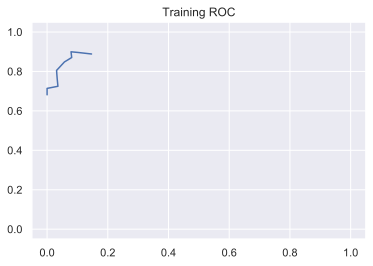

In [45]:
pred_train = model_snippet.predict(X_train)
pred_train_class = np.argmax(pred_train, axis=1)

falsepos = np.zeros(25)
truepos = np.zeros(25)
for threshold in range(25):
    numsnips = n_train_0 + n_train_1
    npts = X_train.shape[0]//(numsnips)
    y_snippet = y_train.reshape(numsnips,numpts)
    prediction_snippet = pred_train_class.reshape(numsnips,numpts)

    snippet_true = np.sum(y_snippet,axis=1) > 0
    snippet_predict = np.sum(prediction_snippet,axis=1) > threshold
    
    CM = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
    falsepos[threshold] = CM[0,1]/(np.sum(CM[:,1])+.01)
    truepos[threshold] = CM[0,0]/(np.sum(CM[:,0])+.01)
    
plt.plot(falsepos,truepos)
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)
plt.title('Training ROC')
print(falsepos)
print(truepos)

Snippet Level Confusion:
[[14  2]
 [ 0 19]]


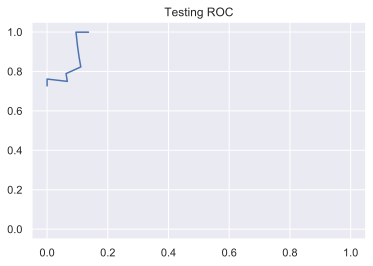

In [46]:
thresholdFromTrain=11

falsepos = np.zeros(25)
truepos = np.zeros(25)
for threshold in range(25):
    numsnips = (num_snips_0-(n_train_0+n_val_0)) + (num_snips_1-(n_train_1+n_val_1))
    numpts = (predict_class.shape[0])//numsnips
    
    prediction_snippet = predict_class.reshape(numsnips,numpts)
    y_snippet = y_test.reshape(numsnips,numpts)

    snippet_true = np.sum(y_snippet,axis=1) > 0
    snippet_predict = np.sum(prediction_snippet,axis=1) > threshold
    
    CM = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
    falsepos[threshold] = CM[0,1]/(np.sum(CM[:,1])+.01)
    truepos[threshold] = CM[0,0]/(np.sum(CM[:,0])+.01)
    
plt.plot(falsepos,truepos)
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)
plt.title('Testing ROC')

snippet_true = np.sum(y_snippet,axis=1) > 0
snippet_predict = np.sum(prediction_snippet,axis=1) > thresholdFromTrain 
CM_test = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )

print('Snippet Level Confusion:')
print(CM_test)

In [47]:
pred_all = model_snippet.predict(Psi)
pred_all_class = np.argmax(pred_all, axis=1)


z_downsample = np.empty((0,zs[0].shape[1]+1), float)
for i in range(len(zs)):
    x = zs[i]
    x = x[0:x.shape[0]-H,:]
    x = x[::step_size]
    if i<z_breakpoint:
        x = np.append(x,np.zeros((x.shape[0],1)),1)
    else:
        x = np.append(x,np.ones((x.shape[0],1)),1)

    z_downsample = np.append(z_downsample,x,0)
    
z_downsample = np.append(z_downsample, manifolder.snip_number.reshape(Psi.shape[0],1), 1)
z_downsample = np.append(z_downsample, pred_all_class.reshape(Psi.shape[0],1), 1)
    
z_downsample.shape

(6592, 4)

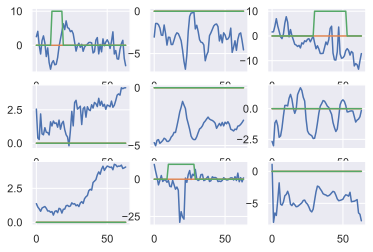

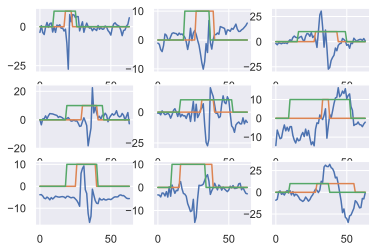

In [48]:
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(z_downsample[snippet_label==snip_test_0[i]][:,5])
    else:
        plt.plot(z_downsample[snippet_label==snip_test_0[i]][:,0])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_0[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_0[i]])
    
plt.show()
 
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(z_downsample[snippet_label==snip_test_1[i]][:,5])
    else:
        plt.plot(z_downsample[snippet_label==snip_test_1[i]][:,0])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_1[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_1[i]])

    
plt.show()

In [131]:
np.savetxt('astro_deep_learning_snippetSplit.csv', z_downsample, delimiter=',', fmt='%f')